# Histopathologic Cancer Detection with Convolutional Neural Network #
Tyler Kinkade

## Overview ##
The aim of this project is to identify metastatic cancer in a test set of 57,458 [histopathologic scans](https://en.wikipedia.org/wiki/Histopathology) of lymph node sections based on a training set of 220,025 labeled, non-duplicate 96-by-96-pixel images from the [Histopathologic Cancer Detection Kaggle Playground Prediction Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection) (Cukierski, 2018). 

Images with at least one pixel of tumor tissue in the center 32-by-32-pixel area are labeled positive (i.e., `label = 1`) in the comma-delimited `train_labels.csv`. The outer region of the image does not affect the label, so unpadded convolutional models are a feasible solution. Image IDs are 40-character hexadecimal strings (e.g., `id = 0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5`).

To achieve the above aim, a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) was applied using the machine-learning software [PyTorch](https://pytorch.org/). ([TensorFlow](https://www.tensorflow.org/) was not utilized because it has [deprecated](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) its utilities for loading images when labels are in a separate CSV.)

This report is organized into four sections: exploratory data analysis, model architecture, results, and conclusion.

## Exploratory Data Analysis ##

In the following exploratory data analysis, I briefly examine the structure of the data, visualize it, and prepare it for analysis in a convolutional neural network. Explanations are interspersed throughout the code blocks below.

### Dataset ###
First, we confirm that there are 220,025 [TIFF](https://en.wikipedia.org/wiki/TIFF) image files in the training samples subdirectory and 57,458 TIFF files in the test samples subdirectory:

In [1]:
# Verify number of samples
# References:
# https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
# https://docs.python.org/2/library/fnmatch.html

import os
import fnmatch

# Base directory
base_path = "/kaggle/input/histopathologic-cancer-detection/"

# Training sample image directory
train_img_path = os.path.join(base_path,"train")

# Test sample image directory
test_img_path = os.path.join(base_path,"test")

print("Training Sample Images:", len(fnmatch.filter(os.listdir(train_img_path), "*.tif")))
print("Test Sample Images:", len(fnmatch.filter(os.listdir(test_img_path), "*.tif")))

Training Sample Images: 220025
Test Sample Images: 57458


The comma-delimited training label data has 220,025 rows and two feature columns: `id`, which matches the image file names, and a binary categorical `label` with 0 corresponding to negative/benign and 1 corresponding to positive/cancerous. Thus, this is a binary classification problem.

In [2]:
# Load training labels CSV into Pandas dataframe
import pandas as pd

train_labels = pd.read_csv(os.path.join(base_path,"train_labels.csv"))
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


41% of the training data samples are labeled cancerous (i.e., 1):

In [3]:
# Number of negative/positive samples
train_labels.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [4]:
# Fraction of negative (0) and positive (1) samples
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
train_labels.label.value_counts(normalize=True)

0    0.594969
1    0.405031
Name: label, dtype: float64

### Visualization ###
This imbalance in the data samples can be visualized as a histogram:

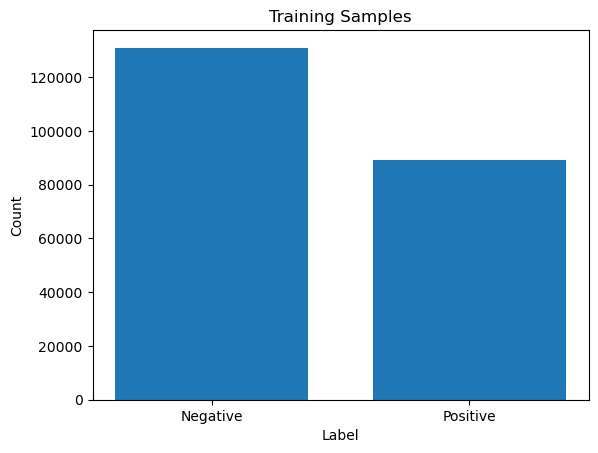

In [5]:
# Histogram of negative/positive training sample count
# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
import matplotlib.pyplot as plt

plt.hist(train_labels.label, bins = 2, rwidth = 0.75);
plt.xticks([0.25,0.75],["Negative","Positive"]);
plt.title("Training Samples");
plt.xlabel("Label")
plt.ylabel("Count");

Visual inspection of a random subset of the images does not reveal any obvious clues as to what distinguishes cancerous and benign samples:

In [6]:
# Randomly select 5 samples from each category (negative/positive)
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.sample.html
five_samples_each = train_labels.groupby('label').sample(n = 5, replace = False, random_state = 1)
five_samples_each

,id,label
1075,971f11c1f84f4124b0d7b03b7efca2749adfa575,0
199138,66ddf87764a69c1a6099e73f3ed0fb34a29418d4,0
205060,8e89d2094c799ede3857ca671f1c9726289eaf9b,0
5049,d46b277543494f1a043568e30179cd0c74c035c6,0
167804,b566ed3dfb101beb300abf779a428e3ae8af035b,0
123087,ddcb965ddb5b8547e3084ab486091f1b6e30e0da,1
134798,e488ae4c3b11a41150ee98b2c71ca073aeb9cb46,1
153828,16fe862d44014e9517d6dfca6338d13f2928ff21,1
209510,d46c360de9198ff21552cab19ee11d187f29577e,1
133193,f1de67063d3cbca93ea5c0e69c89806260a393d7,1


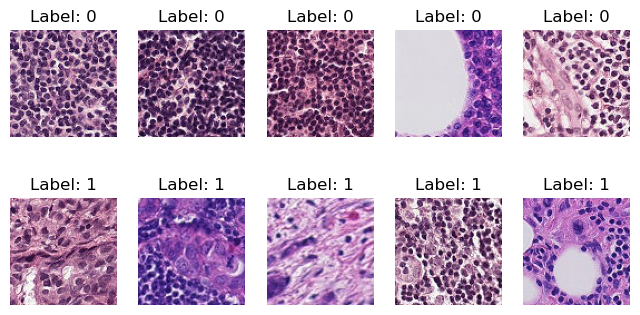

In [7]:
# Display sampled images in a grid
# References: 
# https://www.tensorflow.org/tutorials/load_data/images
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html
# https://realpython.com/python-zip-function/
# https://pillow.readthedocs.io/en/stable/reference/Image.html

import PIL.Image

# Group samples by label
five_samples_each_grouped = five_samples_each.groupby('label')

# Display in matplotlib subplot grid
fig, axs = plt.subplots(2, 5, figsize = (8, 4))
# For each subplot row and sample group (negative/positive)
for ax_row, (label_group, label_rows) in zip(axs, five_samples_each_grouped):
    # For each subplot column and sample row
    for ax_col, (idx, id, label) in zip(ax_row, label_rows.itertuples()):
        img_path = os.path.join(train_img_path, id + ".tif") # TIFF image file location
        ax_col.imshow(PIL.Image.open(img_path))              # Display image
        ax_col.axis("off")                                   # Turn off axis labels
        ax_col.set_title("Label: " + str(label));            # Label the image (0 or 1)

The TIFF images are 96 by 96 pixels:

In [8]:
# Get image dimensions
# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.size
id = five_samples_each['id'].iloc[0]                 # First image in subsample
img_path = os.path.join(train_img_path, id + ".tif") # TIFF image file location
img = PIL.Image.open(img_path)                       # Create Pillow image object
img_width, img_height = img.size                     # Get dimensions
print("Height:", img_height, " px")
print("Width:", img_width, " px")

Height: 96  px
Width: 96  px


### Data Preparation ###
To prepare the data for analysis, balanced* training and validation subsets with a 80%-to-20% split were created by separating the positive and negative image labels of the original training labels dataset and randomly selecting samples from those two subsets such that the size of the training and validation subsets taken together comprised 40% of the original training dataset size.

*NB: Here, balanced means equal numbers of positive- and negative-labeled images.

In [9]:
# Create balanced training and validation datasets by
# separating the original training dataset into negative and positive samples,
# and randomly sampling from each of those separate sets divided into
# training (80%) and validation (20%) subsets
# Taken together, the training and validation subsets are 40% of the original dataset
# References: 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# https://pandas.pydata.org/docs/user_guide/merging.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_index.html

frac = 0.20

# Separate negative and positive samples
labels_negative = train_labels[train_labels["label"] == 0]
labels_positive = train_labels[train_labels["label"] == 1]

# Get size of original training dataset
size = len(train_labels)

# Randomly select negative samples for a training set
negative_train = labels_negative.sample(n = round(size*frac*0.8), replace = False, random_state = 1)

# Randomly select negative samples for a validation set (exclude samples selected for training set)
negative_validation = labels_negative.drop(negative_train.index).sample(n = round(size*frac*0.2), 
                                                                        replace = False, 
                                                                        random_state = 1)

# Randomly select positive samples for a training set
positive_train = labels_positive.sample(n = round(size*frac*0.8), replace = False, random_state = 1)

# Randomly select 2000 positive samples for a validation set
positive_validation = labels_positive.drop(positive_train.index).sample(n = round(size*frac*0.2), 
                                                                        replace = False, 
                                                                        random_state = 1)

# Concatenate training subset
train_frames = [positive_train, negative_train]
train_df = pd.concat(train_frames)

# Sort in place by index
train_df.sort_index(inplace = True)
train_df

,id,label
2,755db6279dae599ebb4d39a9123cce439965282d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0
11,c3d660212bf2a11c994e0eadff13770a9927b731,1
...,...,...
220013,1092801a1d1d7cc8e45b1d909c553ea400615d68,0
220014,309210db7f424edbc22b2d13bf2fa27518b18f5c,1
220016,4236e88fb08d16316395f0e71a0a44c4a6fdf794,0
220017,025427fc9743354111cbbc60cab9be094465602b,0


In [10]:
# Concatenate validation subset
validation_frames = [positive_validation, negative_validation]
validation_df = pd.concat(validation_frames)

# Sort in place by index
validation_df.sort_index(inplace = True)
validation_df

,id,label
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
10,a106469bbfda4cdc5a9da7ac0152927bf1b4a92d,0
16,a1c001f6b242c72d3066f15ac6eb059ea72d30ba,0
51,8bdc54231f7239e2b5c66acb1341391ed651e56f,0
62,240305865761bc3f280f3058cdcf87c669e0a2f7,1
...,...,...
219917,bc3c5fbd6f39fe0c4cbe33887ad6861df8b105ae,1
219925,1f00c3741956a8dabab0cefb4c6ba5e80ce1d46b,1
219960,2d444f24aaeb77d5f8dd1d9e3c90c04e8c4c1fd0,0
219970,5d07402ada9f1ebcdd9815ed71c7b76245771ea2,0


The training and validation subsets have a similar balance of positive and negative samples; 41% are labeled cancerous:

In [11]:
# Fraction of negative (0) and positive (1) training samples
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
train_df.label.value_counts(normalize = True)

0    0.5
1    0.5
Name: label, dtype: float64

In [12]:
# Fraction of negative (0) and positive (1) samples
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
validation_df.label.value_counts(normalize = True)

0    0.5
1    0.5
Name: label, dtype: float64

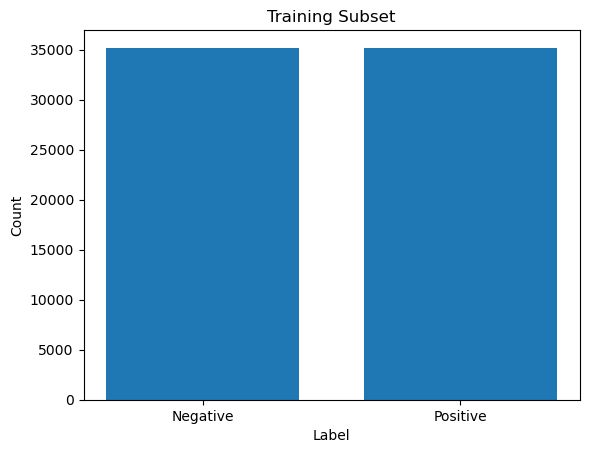

In [13]:
# Histogram of negative/positive training sample count
plt.hist(train_df.label, bins = 2, rwidth = 0.75);
plt.xticks([0.25,0.75],["Negative","Positive"]);
plt.title("Training Subset");
plt.xlabel("Label")
plt.ylabel("Count");

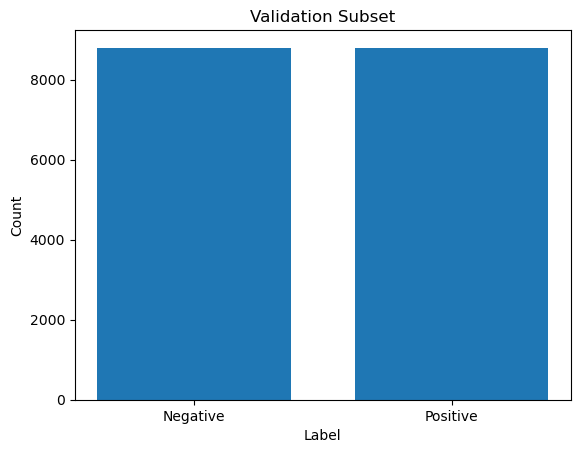

In [14]:
# Histogram of negative/positive validation sample count
plt.hist(validation_df.label, bins = 2, rwidth = 0.75);
plt.xticks([0.25,0.75],["Negative","Positive"]);
plt.title("Validation Subset");
plt.xlabel("Label")
plt.ylabel("Count");

## Model Architecture ##

[Convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) models are appropriate for classifying data with a spatial configuration, such as images or text passages (Heintz, 2021; Karpathy, 2016). Convolution layers ($CONV$) are used to capture the features within an image (Karpathy, 2016). A three-by-three convolution filter with a stride of one is recommended because smaller filters are considered more efficient (Karpathy, 2016). A non-linear activation function must be placed between the layers to prevent the model from collapsing to a one-layer linear model. The rectified linear unit (ReLU) function is commonly selected for this because of its computational simplicity and its consistent, demonstrated effectiveness in previous studies (Karpathy, 2016). This is followed by a two-by-two max-pooling layer ($POOL$) with a stride of two which groups nearby features and also reduced computational complexity (Karpathy, 2016). Pooling also allows us to identify similar features regardless of where those features appear (Goodfellow et al., 2016). This is especially useful in this context because we are interested in identifying when cancer cells are present within the center 32-by-32 pixel region of the image, but not where they appear within that region. The model presented here has an initial convolution layer and ReLU activation function followed by three sets of feature extractor sets (i.e., $[CONV\rightarrow RELU\rightarrow POOL]$). This is followed by a classifier neural network comprised of two fully-connected layers ($FC$) the first has a ReLU activation function and, because this is a binary classification problem, the second has a binary sigmoid activation function for the final output layer.

Using the notation from Karpathy (2016), the model architecture can be summarized as: 

$$INPUT\rightarrow CONV\rightarrow RELU\rightarrow[CONV\rightarrow RELU \rightarrow POOL]\times3\rightarrow FC\rightarrow RELU\rightarrow FC\rightarrow SIGMOID\rightarrow OUTPUT$$

The following code implements this model:

In [15]:
# Define PyTorch neural network
# Adapted from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# References:
# https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html
# https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43
# https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa
# https://discuss.pytorch.org/t/how-to-determined-out-channels/93139
# https://stats.stackexchange.com/questions/128880/number-of-feature-maps-in-convolutional-neural-networks
# https://www.tensorflow.org/tutorials/images/cnn

import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seed for reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(0)


class CNNet(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer takes in 3 channels (RGB) of 32 x 32 px image (as tensor)
        # applies 3 x 3 kernel, and has output dimensions: 8 x 30 x 30
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, 
                               # the following default values are included for clarity:
                               stride = 1, padding = 0, dilation = 1, groups = 1, bias = True)

        # Second convolutional layer: Input: 8 x 30 x 30; Output: 16 x 28 x 28
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3)
        
        # Third convolutional layer: Input: 16 x 14 x 14; Output: 32 x 12 x 12
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)
        
        # Fourth convolutional layer: Input: 32 x 6 x 6; Output: 64 x 4 x 4
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)

        # 2 x 2 max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, 
                                 # the following default values are included for clarity:
                                 padding = 0, dilation = 1, ceil_mode = False)
        
        # Flatten 2D layer to 1D
        self.flatten = nn.Flatten()
        
        # First fully-connected layer: Input 64 x 2 x 2; Output: 1 x 128
        self.fc1 = nn.Linear(64 * 2 * 2, 128)

        # Second fully-connected layer: Input 128; Output: 1 x 1
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Input x dimensions: 3 color channels, 32 x 32 px (as tensor)

        # First feature extractor (CONV->RELU->CONV->RELU->POOL)
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x))))) # Out: 16 x 14 x 14
        
        # Second feature extractor (CONV->RELU->POOL)
        x = self.pool(F.relu(self.conv3(x)))                     # Out: 32 x 6 x 6 
        
        # Third feature extractor (CONV->RELU->POOL)
        x = self.pool(F.relu(self.conv4(x)))                     # Out: 64 x 2 x 2

        # Flatten all dimensions except batch
        x = self.flatten(x)                                      # Out: 1 x 256
        
        # First fully-connected layer
        x = F.relu(self.fc1(x))                                  # Out: 1 x 128

        # Second fully-connected layer
        # Sigmoid function included in loss function
        x = self.fc2(x)                                          # Out: 1 x 1

        return x

Select a GPU training device if possible:

In [16]:
# Select best available training device (i.e., gpu or mps instead of cpu)
# From: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
# References:
# https://pytorch.org/docs/stable/notes/cuda.html
# https://pytorch.org/docs/stable/notes/mps.html
# https://en.wikipedia.org/wiki/CUDA

device = (
    "cuda"    # Compute Unified Device Architecture (GPU)
    if torch.cuda.is_available()
    else "cpu")

print("Device:",device)

Device: cuda


View a summary of the model:

In [17]:
# View model summary
# https://github.com/TylerYep/torchinfo
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180/7

# Instantiate model
model = CNNet().to(device)
print("Model parameters on CUDA:",next(model.parameters()).is_cuda)
print(model)

from torchinfo import summary

summary(model, input_size=(40, 3, 32, 32))

Model parameters on CUDA: True
CNNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CNNet                                    [40, 1]                   --
├─Conv2d: 1-1                            [40, 8, 30, 30]           224
├─Conv2d: 1-2                            [40, 16, 28, 28]          1,168
├─MaxPool2d: 1-3                         [40, 16, 14, 14]          --
├─Conv2d: 1-4                            [40, 32, 12, 12]          4,640
├─MaxPool2d: 1-5                         [40, 32, 6, 6]            --
├─Conv2d: 1-6                            [40, 64, 4, 4]            18,496
├─MaxPool2d: 1-7                         [40, 64, 2, 2]            --
├─Flatten: 1-8                           [40, 256]                 --
├─Linear: 1-9                            [40, 128]                 32,896
├─Linear: 1-10                           [40, 1]                   129
Total params: 57,553
Trainable params: 57,553
Non-trainable params: 0
Total mult-adds (M): 84.58
Input size (MB): 0.49
Forward/backward pas

In [18]:
# Test model with single input
# Adapted from: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html

# Create random tensor equivalent to 3 x 32 x 32 image
data = torch.rand(1, 3, 32, 32).to(device)
print("Input dimensions:",data.shape)

# Obtain result
result = model(data)
print("Output dimensions:",result.shape)
print("Result:",(torch.round(torch.sigmoid(result))).type(torch.uint8)) # Apply sigmoid function

Input dimensions: torch.Size([1, 3, 32, 32])
Output dimensions: torch.Size([1, 1])
Result: tensor([[1]], device='cuda:0', dtype=torch.uint8)


A [custom image dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class was created to load and convert the images selected in the above training and validation dataframes:

In [19]:
# Custom image dataset class
# Adapted from: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert

from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_df, img_dir, img_ext=None, transform=None, target_transform=None):
        self.img_labels = annotations_df         # dataframe of image ids and labels
        self.img_dir = img_dir                   # images directory
        self.img_ext = img_ext                   # image extension (e.g., ".tif")
        self.transform = transform               # PyTorch library transform(s)
        self.target_transform = target_transform # user-defined lambda function transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_filename = self.img_labels.iloc[idx, 0] # image filename
        if self.img_ext:
             img_filename += self.img_ext           # image id + extension
        img_path = os.path.join(self.img_dir, img_filename)
        image = PIL.Image.open(img_path)            # create Pillow image object
        image = image.convert("RGB")                # convert to RGB
        label = self.img_labels.iloc[idx, 1]        # get label (i.e., 0 or 1)
        if self.transform:
            image = self.transform(image)           # apply PyTorch transforms 
        if self.target_transform:
            label = self.target_transform(label)    # apply user-defined transforms 
        return image, label

A transformation will be applied which converts the image pixels into tensors and crops the images to the center 32-pixel square because, as previously mentioned, the classification is based on only the center 32-by-32 center pixels.

In [20]:
# Define PyTorch tensor transforms
# References: 
# https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html

from torchvision import transforms

transformation = transforms.Compose([
    transforms.CenterCrop(32), # Crop to center 32 x 32 pixels
    transforms.ToTensor(),     # Convert PIL image to tensor scaled [0.0, 1.0]
])

# Reference: https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#lambda-transforms
# target_transform = Lambda(lambda y: torch.zeros(
#     10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

The following code creates dataloaders to feed the data into the model in batches.

In [21]:
# Create PyTorch custom datasets
training_data = CustomImageDataset(annotations_df = train_df, 
                                   img_dir = train_img_path, 
                                   img_ext = ".tif", 
                                   transform = transformation, 
                                   target_transform = None)
validation_data = CustomImageDataset(annotations_df = validation_df, 
                                     img_dir = train_img_path, 
                                     img_ext = ".tif", 
                                     transform = transformation, 
                                     target_transform = None)
print("Training data samples:",len(training_data))

Training data samples: 70408


In [22]:
# PyTorch data loaders
# References:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# Batch size hyperparameter
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size, shuffle = False)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle = False)
print("Training batches:",len(train_dataloader))

Training batches: 1101


The following code tests the dataloader and converts one of the tensors back into an image as a sanity check.

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


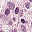

Label: 0


In [23]:
# Iterate through dataloader, print batch shape, and display sample image and label converted from tensor
# Adapted from: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader
# Using references: https://www.tutorialspoint.com/how-to-convert-a-torch-tensor-to-pil-image
# https://discuss.pytorch.org/t/pytorch-pil-to-tensor-and-vice-versa/6312/8
# https://pytorch.org/docs/stable/generated/torch.squeeze.html

train_features, train_labels = next(iter(train_dataloader)) # Iterate through dataloader
print("Feature batch shape:",train_features.size())         # Feature batch dimensions
print("Labels batch shape:",train_labels.size())            # Label batch dimensions
tensor = train_features[0].squeeze()                        # Convert to tensor
transform = transforms.ToPILImage()                         # Transform to convert to PIL image
img = transform(tensor)                                     # Convert tensor to PIL image
label = train_labels[0]                                     # Image label
display(img)
print("Label:",label.item())

## Results ##

This section is divided into model training and validation results and inference test results subsections.

### Model Training and Validation ###

In [24]:
# Training and validation functions
# Adapted from: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# References: 
# https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
# https://github.com/FernandoLpz/Text-Classification-LSTMs-PyTorch/issues/9
# https://stackoverflow.com/questions/57798033/valueerror-target-size-torch-size16-must-be-the-same-as-input-size-torch


def train(dataloader, model, loss_fn, optimizer):
    '''
    Train model, occasionally report current batch accuracy and loss,
    return average epoch accuracy and loss
    '''
    # Set to training mode
    model.train()
    
    # Get dataset size
    size = len(dataloader.dataset)
    
    # Get number of batches
    num_batches = len(dataloader)
    
    # Initialize cumulative loss, number correct accumulators
    cumulative_loss, correct = 0, 0
    
    for batch, (data, target) in enumerate(dataloader):
        # Move data to correct device (GPU or CPU)
        data = data.to(device)
        
        # Target type must match input dtype and size
        target = target.type(torch.FloatTensor).view(-1,1)

        # Move target to correct device (GPU or CPU)
        target = target.to(device)
        
        # Reset gradients
        optimizer.zero_grad()  
        
        # Compute prediction for this batch (forward pass)
        prediction = model(data)

        # Compute loss
        loss = loss_fn(prediction, target)
        
        # Back propagation computes gradient
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Accumulate loss
        cumulative_loss += loss.item()

        # Apply sigmoid function to prediction, round, and compare to target label
        # Accumulate number of correct matches
        correct += (torch.round(torch.sigmoid(prediction)) == target).type(torch.float).sum().item()         

        # Report current loss and for first batch 
        # and every 100 batches thereafter 
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(data)
            print(f"   Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    # Learning rate scheduler
    # scheduler.step()
        
    # Calculate average loss
    avg_loss = cumulative_loss/num_batches
    
    # Calculate average accuracy
    accuracy = correct/size
    
    return avg_loss, accuracy

def validate(dataloader, model, loss_fn):
    '''
    Validate model, occasionally report current batch accuracy and loss,
    return average epoch accuracy and loss
    '''

    # Set to evaluation mode
    model.eval()

    # Get size of validation dataset
    size = len(dataloader.dataset)
    
    # Get number of batches
    num_batches = len(dataloader)
    
    # Initialize cumulative loss, number correct accumulators
    cumulative_loss, correct = 0, 0

    # Without backward propagation
    with torch.no_grad():    
        for batch, (data, target) in enumerate(dataloader):
            # Move data to correct device (GPU or CPU)
            data = data.to(device)
            
            # Target type must match input dtype and size
            target = target.type(torch.FloatTensor).view(-1,1)
            
            # Move target to correct device (GPU or CPU)
            target = target.to(device)
            
            # Calculate prediction
            prediction = model(data)
            
            # Accumulate loss
            loss = loss_fn(prediction, target).item()
            cumulative_loss += loss
            
            # Apply sigmoid function to prediction, round,
            # and compare to target label
            # Accumulate number of matches
            correct += (torch.round(torch.sigmoid(prediction)) == target).type(torch.float).sum().item()

            # Report current loss and for first batch 
            # and every 100 batches thereafter 
            if batch % 100 == 0:
                current = (batch + 1) * len(data)
                print(f"   Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")            
            
    # Calculate average loss
    avg_loss = cumulative_loss/num_batches
    
    # Calculate average accuracy
    accuracy = correct/size
    
    return avg_loss, accuracy


The binary cross entropy loss with logits function is appropriate for binary classifiers and includes the sigmoid function. The [Adam optimization algorithm](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) will be used for optimization. Unlike the
[stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD), Adam optimization maintains and adapts separate learning rates for each parameter (Brownlee, 2017). In preliminary trials, the model converged several training epochs faster than with SGD.

In [25]:
# Set loss function and optimizer
# Adapted from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# References:
# https://pytorch.org/docs/stable/optim.html

import torch.optim as optim

# Binary cross entropy loss function
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
# criterion = nn.BCELoss()

# Binary cross entropy with logits loss function
# includes sigmoid activation function
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
criterion = nn.BCEWithLogitsLoss()

# Learning rate hyperparameter
learning_rate = 0.001

# # Stochastic gradient descent with momentum optimizer
# optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

# Adam optimizer
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Learning rate scheduler
# Reduce learning rate when constant for one epoch
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 1, verbose = True)

The following code block trains and validates the model. Note that model parameter decisions are based on binary cross entropy loss; however, accuracy is also reported because it easily interpreted and it is the metric used to evaluate prediction of the test samples in this competition.

In [26]:
# Train and validate model
# Adapted from: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# References:
# https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
# https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# https://docs.python.org/3/library/copy.html

import copy

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []
best_loss = float('inf') 
best_weights = None

inflection_point_threshold = 3
inflection_point_counter = 0

# Number of training epochs hyperparameter
epochs = 10

# Train/validate and report results for each epoch
for epoch in range(epochs):
    print(f"\n Epoch {epoch + 1}\n-------------------------------")
    # Train model
    print("Training:")
    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"  Accuracy: {(100*train_acc):>0.1f}%, Loss: {train_loss:>8f}")
    
    # Validate model
    print("Validation:")
    val_loss, val_acc = validate(validation_dataloader, model, criterion)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_acc)
    print(f"  Accuracy: {(100*val_acc):>0.1f}%, Loss: {val_loss:>8f}")
              
    # Save model weights if lowest validation loss thus far
    # and inflection point has not already been reached
    if (val_loss < best_loss) and (inflection_point_counter < inflection_point_threshold):
        best_loss = val_loss
        best_weights = copy.deepcopy(model.state_dict())
        print("Saved as best model thus far")
    
    # If loss did not decrease
    elif val_loss >= best_loss:
        # increment inflection point counter
        inflection_point_counter += 1
                      
print("Done!\n")

# Load best model weights
print("Loading best model")
model.load_state_dict(best_weights)


 Epoch 1
-------------------------------
Training:
   Loss: 0.693531  [   64/70408]
   Loss: 0.541099  [ 6464/70408]
   Loss: 0.491375  [12864/70408]
   Loss: 0.423592  [19264/70408]
   Loss: 0.498376  [25664/70408]
   Loss: 0.585800  [32064/70408]
   Loss: 0.517486  [38464/70408]
   Loss: 0.654166  [44864/70408]
   Loss: 0.476395  [51264/70408]
   Loss: 0.513451  [57664/70408]
   Loss: 0.480378  [64064/70408]
   Loss: 0.288052  [ 8808/70408]
  Accuracy: 74.4%, Loss: 0.527601
Validation:
   Loss: 0.528452  [   64/17602]
   Loss: 0.527605  [ 6464/17602]
   Loss: 0.462756  [12864/17602]
  Accuracy: 75.5%, Loss: 0.512743
Saved as best model thus far

 Epoch 2
-------------------------------
Training:
   Loss: 0.579859  [   64/70408]
   Loss: 0.503634  [ 6464/70408]
   Loss: 0.436802  [12864/70408]
   Loss: 0.390380  [19264/70408]
   Loss: 0.415945  [25664/70408]
   Loss: 0.546430  [32064/70408]
   Loss: 0.489239  [38464/70408]
   Loss: 0.617436  [44864/70408]
   Loss: 0.431025  [51264/70

<All keys matched successfully>

To avoid overfitting, it is important to choose model parameters based on the validation metrics (rather than the training metrics). Cross entropy loss was used as the criterion for selection. Accuracy is included here because of its interpretability and its use as the metric for this competition. (In a clinical setting, false-negative rate would be a more appropriate metric.) Around the eighth training epoch, the validation loss appears to have reached an inflection point. Therefore, the model parameters (i.e., weights) from this point were selected as the best model for predicting the test samples.

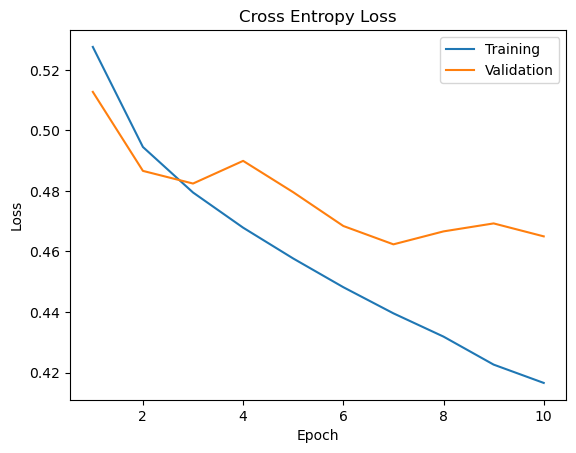

In [27]:
# Plot training and validation loss
import numpy as np
epoch_axis = np.arange(1,epochs + 1)
plt.plot(epoch_axis, train_losses, label="Training")
plt.plot(epoch_axis, validation_losses, label="Validation")
plt.title("Cross Entropy Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss");

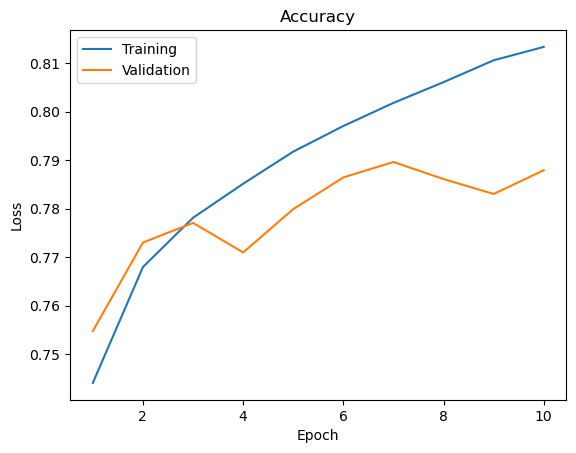

In [28]:
# Plot training and validation accuracy
plt.plot(epoch_axis, train_accuracies, label="Training")
plt.plot(epoch_axis, validation_accuracies, label="Validation")
plt.title("Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss");

### Inference Test ###

In [29]:
# Load test labels CSV into Pandas dataframe
test_labels = pd.read_csv(os.path.join(base_path,"sample_submission.csv"))
test_labels

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [30]:
# Create test dataset
test_data = CustomImageDataset(annotations_df = test_labels, 
                                   img_dir = test_img_path, 
                                   img_ext = ".tif", 
                                   transform = transformation, 
                                   target_transform = None)
print("Test data samples:",len(test_data))

Test data samples: 57458


In [31]:
# Create data loader

test_dataloader = DataLoader(test_data, batch_size, shuffle = False)
print("Test batches:",len(test_dataloader))

Test batches: 898


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


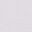

Label: 0


In [32]:
# Iterate through dataloader, print batch shape, and display sample image and label converted from tensor
features, labels = next(iter(test_dataloader)) # Iterate through dataloader
print("Feature batch shape:",features.size())  # Feature batch dimensions
print("Labels batch shape:",labels.size())     # Label batch dimensions
tensor = features[0].squeeze()                 # Convert to tensor
transform = transforms.ToPILImage()            # Transform to convert to PIL image
img = transform(tensor)                        # Convert tensor to PIL image
label = labels[0]                              # Image label
display(img)
print("Label:",label.item())

In [33]:
def inference(dataloader, model):
    '''
    Use model to predict output based on input data
    '''
    # Get dataset size
    size = len(dataloader.dataset)
    
    # Set to evaluation mode (i.e., not training)
    model.eval()
      
    labels = []
    
    # Without backward propagation
    with torch.no_grad():    
        for batch, (data, label) in enumerate(dataloader):
            # Move data to correct device (GPU or CPU)
            data = data.to(device)
            label = label.to(device)

            # Calculate prediction and apply sigmoid function
            output = torch.sigmoid(model(data))
            
            # Convert to numpy array stored on cpu
            predictions = output.detach().cpu().numpy().flatten()
            
            # Append to labels list
            for prediction in predictions:
                labels.append(prediction)
                       
            # Report current iteration for first batch 
            # and every 100 batches thereafter 
            if batch % 100 == 0:
                current = (batch + 1) * len(data)
                print(f"Images processed: {current:>5d}/{size:>5d}")

    return labels

In [34]:
# Get predicted labels for test data
test_labels["label"] = inference(test_dataloader, model)
test_labels.head(10)

Images processed:    64/57458
Images processed:  6464/57458
Images processed: 12864/57458
Images processed: 19264/57458
Images processed: 25664/57458
Images processed: 32064/57458
Images processed: 38464/57458
Images processed: 44864/57458
Images processed: 51264/57458


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.046688
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.193259
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.099430
3,2c35657e312966e9294eac6841726ff3a748febf,0.234493
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.579975
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.094960
6,aa0307865281d4484ddf8c637c348292968b93a7,0.992846
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.778073
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.600874
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.971548


In [35]:
test_labels.tail(10)

,id,label
57448,5481ea07d17fed3a807294a1c2ddbba2a64eb9e3,0.975544
57449,d5b3051b33d56ae6b46069225739ba2005d3ae61,0.045339
57450,69097bf5ae9632515d2e70c7cd3880ea7980820c,0.098700
57451,a3c0f54a1e82f1bb3f9527eb619cec2bb229fa5d,0.101392
57452,f93cadad45c3d7763af25d3412bd0019a95fa0f1,0.814822
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0.196910
57454,6f3977130212641fd5808210015a609c658dcbff,0.131494
57455,46935f247278539eca74b54d07d666efb528a753,0.022341
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0.379036
57457,d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b,0.044372


In [36]:
# Fraction of negative (0) and positive (1) samples
test_labels.label.value_counts(normalize = True, bins = 2)

(-0.001731, 0.499]    0.524366
(0.499, 0.999]        0.475634
Name: label, dtype: float64

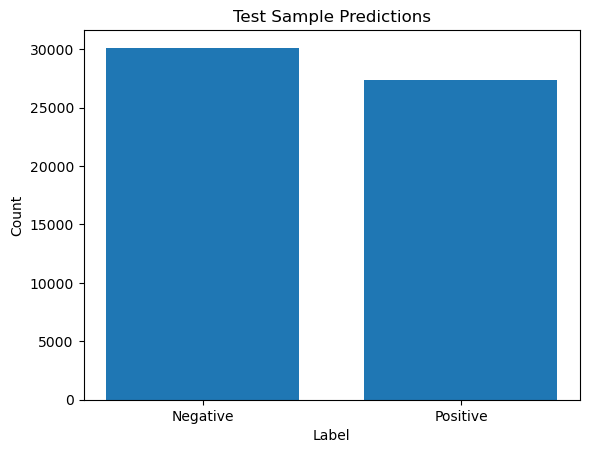

In [37]:
# Histogram of predicted negative/positive test samples
plt.hist(test_labels.label, bins = 2, rwidth = 0.75);
plt.xticks([0.25,0.75],["Negative","Positive"]);
plt.title("Test Sample Predictions");
plt.xlabel("Label")
plt.ylabel("Count");

In [38]:
# Create submission CSV
test_labels.to_csv("submission.csv", index = False)

## Conclusion ##

A convolutional neural network model of four convolutions with ReLU activation, three pooling layers, and two fully-connected layers was trained on the center 32-pixel square on a balanced set of 32% of the original training data using a binary cross entropy loss function, Adam optimization, and batches of 64 samples followed by validation on a balanced set of 8% of the original training dataset (the 32% training data were excluded before sampling the validation data). The lowest validation cross entropy loss of approximately 0.46 and 79% accuracy was achieved around the seventh epoch. The model from this training epoch was used to identify cancerous samples in the test dataset. Roughly 47% of the test samples were identified as cancerous. The submitted test dataset labels received a Kaggle public score of 87%.

## References ##

Brownlee, J. (2017, July 3). Gentle introduction to the Adam optimization algorithm for deep learning. Machine Learning Mastery. [https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

Cukierski, W. (2018). _Histopathologic cancer detection._ Kaggle. [https://kaggle.com/competitions/histopathologic-cancer-detection](https://kaggle.com/competitions/histopathologic-cancer-detection)

Goodfellow, I., Bengio, Y., & Courville, A. (2016). _Deep learning._ MIT Press. [http://www.deeplearningbook.org](http://www.deeplearningbook.org)

Heintz, B. (2021, April 17). _Building models with Pytorch._ Pytorch. [https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#building-models-with-pytorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html#building-models-with-pytorch)

Karpathy, A. (2016). _Convolutional neural networks for visual recognition._ Stanford University. [https://cs231n.github.io/convolutional-networks/](https://cs231n.github.io/convolutional-networks/)

Matplotlib. (2023). _API reference._ [https://matplotlib.org/stable/api/index](https://matplotlib.org/stable/api/index)

Pillow. (2023). _Pillow documentation._ [https://pillow.readthedocs.io/en/stable/index.html](https://pillow.readthedocs.io/en/stable/index.html)

Pytorch. (2023). _Pytorch documentation._ [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

Tensorflow. (2021, May 22). _Convolutional neural network._ [https://www.tensorflow.org/tutorials/images/cnn](https://www.tensorflow.org/tutorials/images/cnn) 

